## Crawling and Extracting Data from Websites

This module uses a set of non-standard libraries, which need to be installed on your machine. By default, your instance should have these installed, but if this is not the case, type these in the Unix shell prompt

`sudo apt-get install libxml2-dev libxslt-dev python-dev` 

and then

`sudo pip install lxml`

`sudo pip install pandas`

It will take a few minutes to get everything installed.

### Fetching the headlines from ESPN.com

Let's start by trying to fetch the headlines from the site ESPN.com.



In [ ]:
import requests # This command allows us to fetch URLs
from lxml import html # This module will allow us to parse the returned HTML/XML
import pandas # To create a dataframe

# Let's start by fetching the page, and parsing it
url = "http://www.espn.com/"
response = requests.get(url) # get the html of that url
doc = html.fromstring(response.text) # parse it and create a document

The `doc` variable is an `HtmlElement` object, and we can now use **XPath** queries to locate the elements that we need. (Depending on time, we may do in class a tutorial on XPath. For now, you can look at the [W3Schools tutorial](http://www.w3schools.com/xpath/xpath_nodes.asp))

For example, to find all the `<a ...> ... </a>` tags in the returned html, which store the links in the page, we issue the command:

In [ ]:
links = doc.findall(".//a")
len(links)

In [ ]:
print links

In [ ]:
lnk = links[45]
type(lnk)
print lnk

The `lnk` variable is again an HtmlElement. To get parts of the html element that we need, we can use the `get` method (e.g., to get the `href` attribute) and the `text_content` method (to get the text within the `<a>...</a>` tag.

In [ ]:
print lnk.get("href")
print lnk.text_content()

Now, let's revisit the _list comprehension_ approach that we discussed in the Python Primer session, for quickly constructing lists:

In [ ]:
urls = [lnk.get("href") for lnk in doc.findall('.//a')]
urls

#### Exercise

Use a list compresension approach, to get the text_content of all the URLs in the page.

In [ ]:
# your code here

And now create a list where we put together text content and the URL for each link

In [ ]:
# your code here

#### Let's get the headlines...

Now, let's examine how we can get the data from the website. The key is to understand the structure of the HTML, where the data that we need is stored, and how to fetch the elements. Then, using a combination of `find` and `findall` commands, together with the appropriate XPath queries, we will get what we want

In [ ]:
import requests # This command allows us to fetch URLs
from lxml import html # This module will allow us to parse the returned HTML/XML
import pandas # To create a dataframe

# Let's start by fetching the page, and parsing it
url = "http://www.espn.com/"
response = requests.get(url) # get the html of that url
doc = html.fromstring(response.text) # parse it and create a document

# By using the "Right-Click > Inspect" option of Chrome,
# we right click on the headlines and select "Inspect".
# This opens the source code.
# There we see that all under a <ul class="headlines"> tag
# which is also the only such tag in the html source
# So, we can use the "find" command (instead of the "findall", 
# which would return a list, with just a single entry in this case)
headlineNode = doc.find('.//div[@class="headlines"]') 

# Each headline is under a  <li><a href="...."></a> 
# tag. We also notice that there are two <a></a> tags within
# each <li>, and we only need the first one.
# So, we get all the <li><a ...> tags within the <ul class="headlines">
# (which is stored in the "headlineNode" variable)
headlines = headlineNode.findall('./ul/li/a')


In [ ]:
# Now, we have the nodes with the conent in the headlines variable
# We extract the text and the URL
data = [(a.text_content(), a.get("href")) for a in headlines]

data

In [ ]:
# And let's create our dataframe
dataframe = pandas.DataFrame(data, columns=["Title", "URL"])

In [ ]:
dataframe

### Parsing Yahoo Finance (Advanced Example)

Let's try to parse the page from Yahoo Finance that contains the Options prices for YHOO (or any other company, actually). Let's start with the standard process of fetching the URL, and parsing the content into a document/tree:

In [ ]:
import requests # This command allows us to fetch URLs
from lxml import html # This module will allow us to parse the returned HTML/XML

url = "http://finance.yahoo.com/q/op?s=YHOO+Options"

# get the html of that url
response = requests.get(url)

# Parse the html into a tree
doc = html.fromstring(response.text)
print doc

#### Getting the data that we want

Now, let's say that we want to get the prices for the different options. Scraping HTML is a little bit of an art, and sometimes involves trial and error, as the html formatting of the page can change at any point.

To see where the data is stored, we need to look at the HTML, and try to understand the structure of what surrounds our data of interest. For our case, we see that the prices are stored in an HTML `<table>` element. The table also contains the attribute `class="details-table quote-table Fz-m"`. So, we fetch these two tables, and we ensure that we have two such tables (the call and put) in our results:

In [ ]:
tables = doc.findall('.//table[@class="details-table quote-table Fz-m"]')
len(tables)
print tables

In [ ]:
# The first table contains the calls and the second contains the puts
calls = tables[0] 

puts = tables[1]


Now, we want to again parse the content of these tables. For that, we get back a list of elements that contain "table rows" which are the `<tr>...</tr>` elements. Let's get these now:

In [ ]:
calls_rows = calls.findall('.//tr')
puts_rows = puts.findall('.//tr')

Now, within the `<tr>` nodes (that represent table rows) we see a set of `<td></td>` elements that contain the cells of each row. You will also notice that the first row contains `<th></th>` cells instead of `<td></td>`; the `<th></th>` cells are commonly used to mark the "headers" of the table.

Above, you have seen how we can use list comprehensions to get back the data that we want in a list format. Now, we will write a function that will return us directly the text content of the cells in the table

In [ ]:
# This function takes as input a "tr" node
# and returns a list of the text content for each
# of the cells. To avoid creating two functions,
# one for header (<th>) cells and one for data (<td>) cells
# we pass a parameter isHeader that specifies that we are 
# extracting from
def extractCells(row, isHeader=False):
    if isHeader:
        cells = row.findall('.//th')
    else:
        cells = row.findall('.//td')
        
    # The ...strip().splitlines()[0] is not strictly necessary, but it helps for beautifying the headers
    return [val.text_content().strip().splitlines()[0] for val in cells]

For now, let's get the contents of the header row:

In [ ]:
extractCells(calls_rows[0], isHeader=True)

And let's get the contents of the first row:

In [ ]:
extractCells(calls_rows[2], isHeader=False)

Now, out goal is to take all the above, and put them together. We will first create a function that takes the "table" object as a parameter, and creates a DataFrame object, with the headers of the table as headers for the DataFrame and the table rows become the rows of the DataFrame.

In [ ]:
import pandas

def parse_options_data(table):
    rows = table.findall(".//tr")
    header = extractCells(rows[0], isHeader=True)
    data = [extractCells(row, isHeader=False) for row in rows[2:]]
    return pandas.DataFrame(data, columns=header)


Now, let's put everything together:

In [1]:
import requests # This command allows us to fetch URLs
from lxml import html # This module will allow us to parse the returned HTML/XML
from pandas.io.parsers import TextParser
import pandas

def extractCells(row, isHeader=False):
    if isHeader:
        cells = row.findall('.//th')
    else:
        cells = row.findall('.//td')
    return [val.text_content().strip().splitlines()[0] for val in cells]

def parse_options_data(table):
    rows = table.findall(".//tr")
    header = extractCells(rows[0], isHeader=True)
    data = [extractCells(row, isHeader=False) for row in rows[2:]]
    return pandas.DataFrame(data, columns=header)

url = "http://finance.yahoo.com/q/op?s=YHOO+Options"
response = requests.get(url) # get the html of that url
doc = html.fromstring(response.text) 

tables = doc.findall('.//table[@class="details-table quote-table Fz-m"]')
calls = tables[0] 
print calls
puts = tables[1] 
print puts
call_data = parse_options_data(calls)
put_data = parse_options_data(puts)

<Element table at 0x7ff5bc863aa0>
<Element table at 0x7ff5bc863998>


In [2]:
call_data

,Strike,Contract Name,Last,Bid,Ask,Change,%Change,Volume,Open Interest,Implied Volatility
0,24.50,YHOO160304C00024500,2.87,7.65,7.95,0.00,0.00%,448,176,0.00%
1,25.00,YHOO160304C00025000,4.64,6.70,7.60,0.00,0.00%,2,12,153.91%
2,26.00,YHOO160304C00026000,3.50,5.45,6.65,0.00,0.00%,5,5,147.66%
3,26.50,YHOO160304C00026500,4.45,5.70,6.15,0.00,0.00%,2,12,137.89%
4,27.00,YHOO160304C00027000,4.26,4.90,5.45,0.00,0.00%,1,1,0.00%
5,27.50,YHOO160304C00027500,4.75,0.00,0.00,0.00,0.00%,102,139,0.00%
6,28.00,YHOO160304C00028000,4.35,0.00,0.00,0.00,0.00%,150,759,0.00%
7,28.50,YHOO160304C00028500,2.97,3.30,3.95,0.00,0.00%,2,68,0.00%
8,29.00,YHOO160304C00029000,3.24,3.15,3.40,0.00,0.00%,1,321,0.00%
9,29.50,YHOO160304C00029500,2.00,0.00,0.00,0.00,0.00%,7,157,0.00%


And let's plot the data:

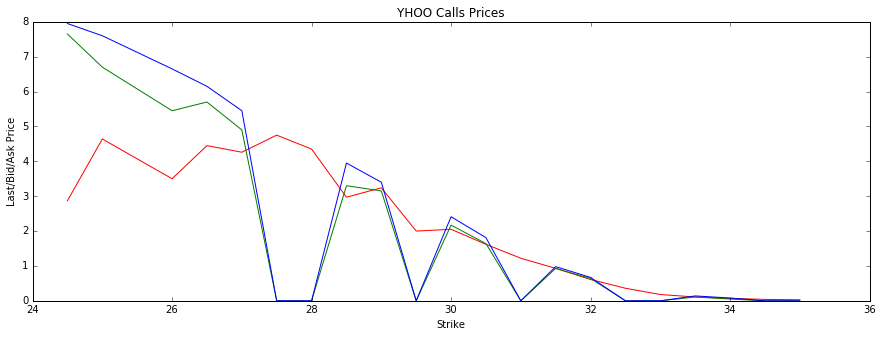

In [3]:
# Render our plots inline
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

# Make the graphs a bit prettier, and bigger
# Do not need to understand these commands
plt.rcParams['figure.figsize'] = (15, 5)

X = call_data["Strike"]
Y = call_data["Last"]
plt.plot(X, Y, 'r-')

Y = call_data["Bid"]
plt.plot(X, Y, 'g-')

Y = call_data["Ask"]
plt.plot(X, Y, 'b-')


plt.title('YHOO Calls Prices')
plt.xlabel('Strike')
plt.ylabel('Last/Bid/Ask Price')

### In Class Example: Crawl BuzzFeed

* We will try to get the top articles that appear on Buzzfeed
* We will grab the link for the article, the text of the title, the description, and the editor.
* The results will be stored in a dataframe (we will see in detail what a dataframe is, in a couple of modules)


In [ ]:
#your code here

#### Solution for Buzzfeed (as of March 1st, 2016)

In [27]:
import requests # This command allows us to fetch URLs
from lxml import html # This module will allow us to parse the returned HTML/XML
import pandas

# Let's start by fetching the page, and parsing it
url = "http://www.buzzfeed.com/"
response = requests.get(url) # get the html of that url
doc = html.fromstring(response.text) # parse it and create a document

articleNodes = doc.xpath(".//ul[contains(@class,'grid-posts')]//div[@class='lede ']/div[@class='lede__body']") 
print len(articleNodes)

def parseArticleNode(article):
    headline = article.find(".//h2[@class='lede__title lede__title--medium']/a[@class='lede__link']")
    if headline == None:
        return dict()
    headline_text = headline.text_content()[2:]
    headline_link = headline.get("href").strip()
    
    description = article.find("./p[@class='lede__kicker']")
    if description == None:
        description_text = None
    else:
        description_text = description.text_content().strip()
    
    editor = article.find('.//a[@editor]') 
    if editor == None:
        editor_text = None
    else:
        editor_text = editor.text_content().strip()
    
    result = {
        "headline": headline_text,
        "URL" : headline_link,
        "description" : description_text,
        "editor" : editor_text
    }
    return result

data = [parseArticleNode(article) for article in articleNodes]
df = pandas.DataFrame(data)
df

89


,URL,description,editor,headline
0,/kateh45/things-youll-understand-when-you-date...,You have an insane amount of kitchenware.,Kate Jordan,21 Things You'll Understand If You're D...
1,/krystieyandoli/heres-the-official-cover-for-b...,Is it September yet?!,Krystie Lee Yandoli,Here's The Official Cover For Beatrix P...
2,/caseygueren/symptoms-all-coffee-addicts-have-...,"It's not a yawn, it's a desperate cry for cold...",Casey Gueren,17 Symptoms All Coffee Addicts Have Exp...
3,/leticiamiranda/hannah-and-hammy-the-cow,Hammy the Cow has been with her through 300 ni...,Leticia Miranda,This Woman With A Rare Disease Wants To...
4,/angelospagnolo/backpacks-that-wont-make-you-l...,"Pack it up, pack it in.",Angelo Spagnolo,27 Backpacks For Grown-Ass Adults\n
5,/robinedds/how-observant-are-you,Good luck. You'll need it.,Robin Edds,How Observant Are You?\n
6,/eleanorbate/come-on-neil,"""YOU HAVE TO SAY A PROPER YES, BRUV!""",Ellie Bate,Adele Helped A Fan Propose On The First...
7,/kimberleydadds/stacey-dash-reads-mean-tweets-...,"""I'm very happy about what I did and I'm proud...",Kimberley Dadds,Stacey Dash Has Responded To Her Awkwar...
8,/davidmack/puppy-braceface,We all wished we looked this cute with braces ...,David Mack,A Puppy With Braces Is Breaking Hearts ...
9,/jessicamisener/this-journey-we-are-on,All-night rose ceremonies! No condoms in the f...,Jessica Misener,"25 Behind-The-Scenes Secrets About ""The..."
